In [1]:
import os, random, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
from collections import Counter
from datetime import datetime
from sklearn.model_selection import train_test_split
import torch
from torchinfo import summary
from torch import nn, accelerator
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.tensorboard import SummaryWriter

def set_seed(seed: int = 123):
    random.seed(seed)
    np.random.seed(seed)
    os.environ.get('PYTHONHASHSEED') == str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False

device = accelerator.current_accelerator() if accelerator.is_available() else torch.device('cpu')

2025-09-27 08:11:42.361437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758960702.740013      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758960702.849411      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dir_path = Path('/kaggle/input/fer2013')
train_dir = dir_path / 'train'
test_dir = dir_path / 'test'

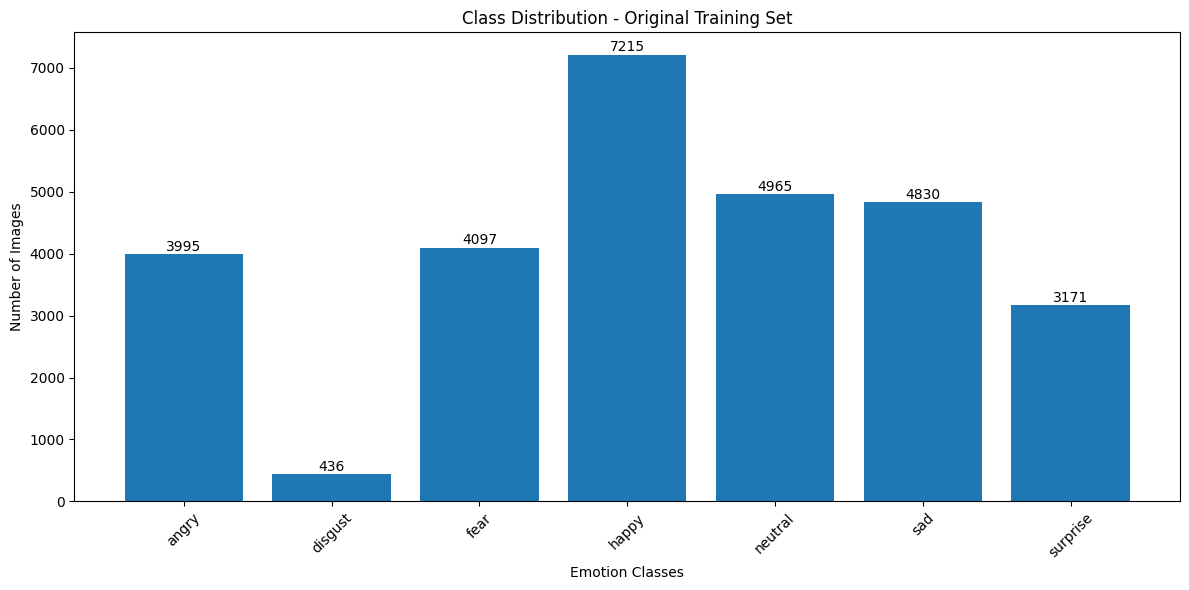

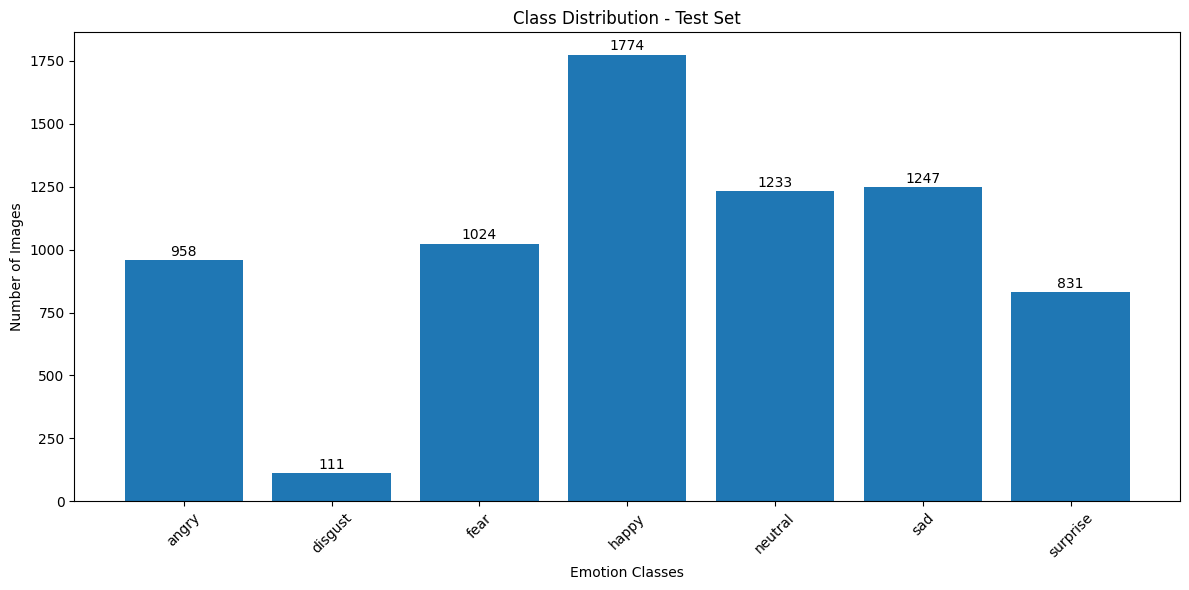

In [3]:
def plot_class_distribution(data_dir, title):

    class_counts = {}
    class_names = sorted([d.name for d in data_dir.iterdir() if d.is_dir()])
    
    for class_name in class_names:
        class_dir = data_dir / class_name
        class_counts[class_name] = len(list(class_dir.glob('*.*')))

    plt.figure(figsize=(12, 6))
    bars = plt.bar(class_counts.keys(), class_counts.values())
    plt.title(f'Class Distribution - {title}')
    plt.xlabel('Emotion Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)

    for bar, count in zip(bars, class_counts.values()):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                str(count), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return class_counts


train_counts = plot_class_distribution(train_dir, 'Original Training Set')
test_counts = plot_class_distribution(test_dir, 'Test Set')

In [4]:
base_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_transform_geo = transforms.Compose([
    transforms.Resize((224, 224)),
    # --- GEOMETRIC AUGS START ---
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    # --- GEOMETRIC AUGS END ---
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_transform_geo_ngeo = transforms.Compose([
    transforms.Resize((224, 224)),
    # --- COLOR AUGS START ---
    # scale down the color jitter from 0.2 to 0.1
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.GaussianBlur(kernel_size=(3, 3)), # You can add this too
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    # --- COLOR AUGS END ---
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_train_dataset = datasets.ImageFolder(train_dir)


train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

class TransformDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        self.classes = subset.dataset.classes
        self.class_to_idx = subset.dataset.class_to_idx

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)

        return x, y
        

train_subset, val_subset = random_split(full_train_dataset, [train_size, val_size])

val_dataset = TransformDataset(val_subset, base_transforms)
test_dataset = datasets.ImageFolder(test_dir, base_transforms)
class_names = full_train_dataset.classes

In [5]:
# Load train, val, dan test dataloaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()


# train_dl = DataLoader(train_dataset, 
#                       batch_size=BATCH_SIZE,
#                       shuffle=True,
#                       pin_memory=True,
#                       num_workers=NUM_WORKERS)
val_dl = DataLoader(val_dataset,
                    batch_size=BATCH_SIZE,
                    shuffle=False,
                    pin_memory=True,
                    num_workers=NUM_WORKERS)
test_dl = DataLoader(test_dataset, 
                      batch_size=BATCH_SIZE,
                      shuffle=False,
                      pin_memory=True,
                      num_workers=NUM_WORKERS)

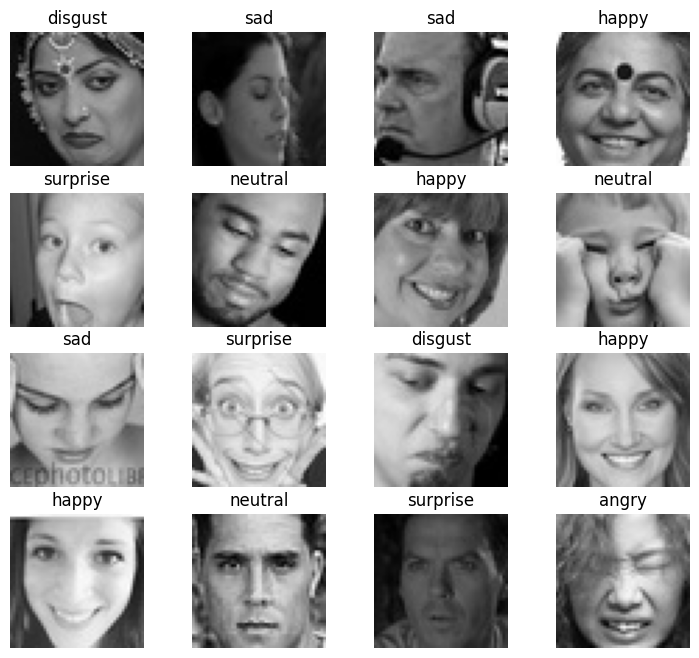

In [6]:
fig = plt.figure(figsize=(9,8))
rx, cy = 4, 4

for i in range(1, rx * cy + 1):
    r_idx = np.random.randint(0, len(full_train_dataset), size=1).item()
    img, label = full_train_dataset[r_idx]
    fig.add_subplot(rx, cy, i)
    plt.imshow(img)
    plt.title(f"{class_names[label]}")
    plt.axis(False);
# num_classes = len(class_names)
# cols = num_classes  # all in one row
# rows = 1

# fig, axes = plt.subplots(rows, cols, figsize=(2*cols, 2.5))  # scale with cols

# rng = np.random.default_rng(42)  # reproducible

# for i, ax in enumerate(axes):
#     # get one random sample for each class
#     indices = [idx for idx, (_, label) in enumerate(full_train_dataset) if label == i]
#     choice = rng.choice(indices)
#     img, label = full_train_dataset[choice]
#     plt.savefig("dataset_examples.png", dpi=300)  # save as PNG
#     ax.imshow(img, cmap="gray")  # minimalist = grayscale
#     ax.set_title(class_names[label], fontsize=12, pad=4)
#     ax.axis("off")

# plt.tight_layout()
# plt.show()

In [7]:
class BaseNet(nn.Module):
    def __init__(self, num_classes):
        super(BaseNet, self).__init__()
        self.conv_block1= nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.conv_block2= nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_block2(self.conv_block1(x))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [8]:
def create_writer(exp_name, model_name='plainCNN', extra=None):
    timestamp = datetime.now().strftime("%Y-%m-%d")
    
    if extra:
        log_dir = os.path.join('runs', timestamp, exp_name, model_name, extra)
    else:
        log_dir = os.path.join('runs', timestamp, exp_name, model_name)
        
    print(f"Created SummaryWriter: saving to: {log_dir}")
    return SummaryWriter(log_dir=log_dir)
    
def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss, train_acc = 0, 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        y_preds = outputs.argmax(dim=1)
        train_acc += (y_preds == y).sum().item() / len(y_preds)
        
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

def val_step(model, dataloader, loss_fn, optimizer, device):
    model.eval()
    
    val_loss, val_acc = 0, 0
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = loss_fn(outputs, y)
            val_loss += loss.item()
            y_preds = outputs.argmax(dim=1)
            val_acc += (y_preds == y).sum().item() / len(y_preds)

    val_loss /= len(dataloader)
    val_acc /= len(dataloader)
    return val_loss, val_acc

# Train step
def train(model, train_dl, val_dl, optimizer, loss_fn, epochs, device, scheduler=None, writer=None):

    results = {'train_loss': [], 'train_acc': [],
               'val_loss': [], 'val_acc': []}
    for epoch in range(epochs):
        
        train_loss, train_acc = train_step(model, train_dl, loss_fn, optimizer, device)
            
        val_loss, val_acc = val_step(model, val_dl, loss_fn, optimizer, device)

        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

        
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['val_loss'].append(val_loss)
        results['val_acc'].append(val_acc)

        print(
            f"Epoch {epoch+1:03}/{epochs:03} | "
            f"Loss: {train_loss:.4f} | Acc: {train_acc*100:.2f}% | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%"
        )
        if writer:
            writer.add_scalars(main_tag='Loss',
                              tag_scalar_dict={'train_loss': train_loss,
                                             'val_loss': val_loss},
                              global_step=epoch)
            writer.add_scalars(main_tag='Accuracy',
                              tag_scalar_dict={'train_acc': train_acc,
                                              'val_acc': val_acc},
                              global_step=epoch)
            writer.close()
        else:
            pass
            
    return results


[INFO] Experiment number: 1
[INFO] Transform Approach: no_aug
------------------------------------------------------------
Created SummaryWriter: saving to: runs/2025-09-27/no_aug/baseline_cnn
Epoch 001/030 | Loss: 1.8014 | Acc: 24.81% | Val Loss: 1.7980 | Val Acc: 25.22%
Epoch 002/030 | Loss: 1.7770 | Acc: 27.01% | Val Loss: 1.7751 | Val Acc: 26.71%
Epoch 003/030 | Loss: 1.7673 | Acc: 27.82% | Val Loss: 1.7549 | Val Acc: 27.35%
Epoch 004/030 | Loss: 1.7580 | Acc: 27.79% | Val Loss: 1.7506 | Val Acc: 28.65%
Epoch 005/030 | Loss: 1.7509 | Acc: 28.97% | Val Loss: 1.7435 | Val Acc: 29.42%
Epoch 006/030 | Loss: 1.7462 | Acc: 29.11% | Val Loss: 1.7385 | Val Acc: 28.93%
Epoch 007/030 | Loss: 1.7391 | Acc: 29.56% | Val Loss: 1.7257 | Val Acc: 29.33%
Epoch 008/030 | Loss: 1.7313 | Acc: 29.94% | Val Loss: 1.7215 | Val Acc: 31.16%
Epoch 009/030 | Loss: 1.7210 | Acc: 30.38% | Val Loss: 1.6951 | Val Acc: 31.48%
Epoch 010/030 | Loss: 1.7125 | Acc: 30.61% | Val Loss: 1.6887 | Val Acc: 31.92%
Epoch 

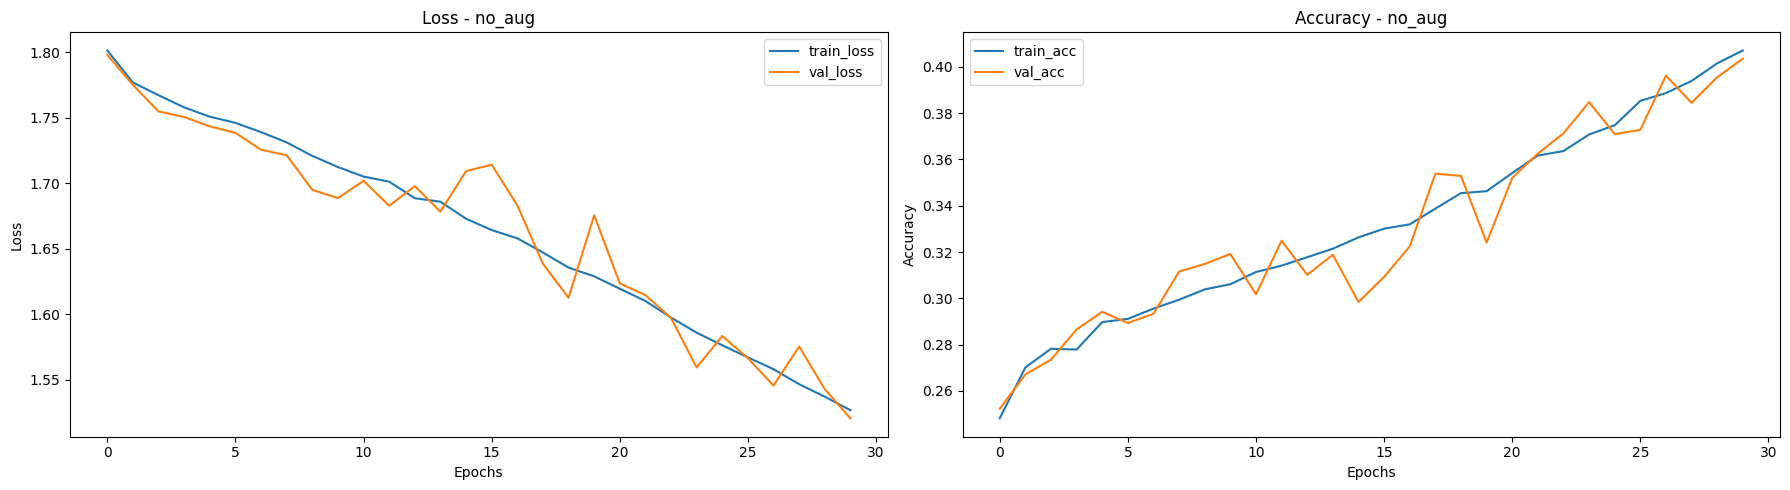



[INFO] Experiment number: 2
[INFO] Transform Approach: geo_aug
------------------------------------------------------------
Created SummaryWriter: saving to: runs/2025-09-27/geo_aug/baseline_cnn
Epoch 001/030 | Loss: 1.8074 | Acc: 24.67% | Val Loss: 1.7888 | Val Acc: 25.12%
Epoch 002/030 | Loss: 1.7863 | Acc: 25.52% | Val Loss: 1.8022 | Val Acc: 24.17%
Epoch 003/030 | Loss: 1.7816 | Acc: 26.43% | Val Loss: 1.7862 | Val Acc: 25.61%
Epoch 004/030 | Loss: 1.7777 | Acc: 26.62% | Val Loss: 1.7777 | Val Acc: 26.19%
Epoch 005/030 | Loss: 1.7721 | Acc: 27.07% | Val Loss: 1.7659 | Val Acc: 26.99%
Epoch 006/030 | Loss: 1.7655 | Acc: 27.50% | Val Loss: 1.7568 | Val Acc: 27.70%
Epoch 007/030 | Loss: 1.7589 | Acc: 27.79% | Val Loss: 1.7445 | Val Acc: 28.56%
Epoch 008/030 | Loss: 1.7513 | Acc: 28.62% | Val Loss: 1.7423 | Val Acc: 28.41%
Epoch 009/030 | Loss: 1.7478 | Acc: 28.90% | Val Loss: 1.7392 | Val Acc: 28.41%
Epoch 010/030 | Loss: 1.7423 | Acc: 29.04% | Val Loss: 1.7283 | Val Acc: 30.25%
Epo

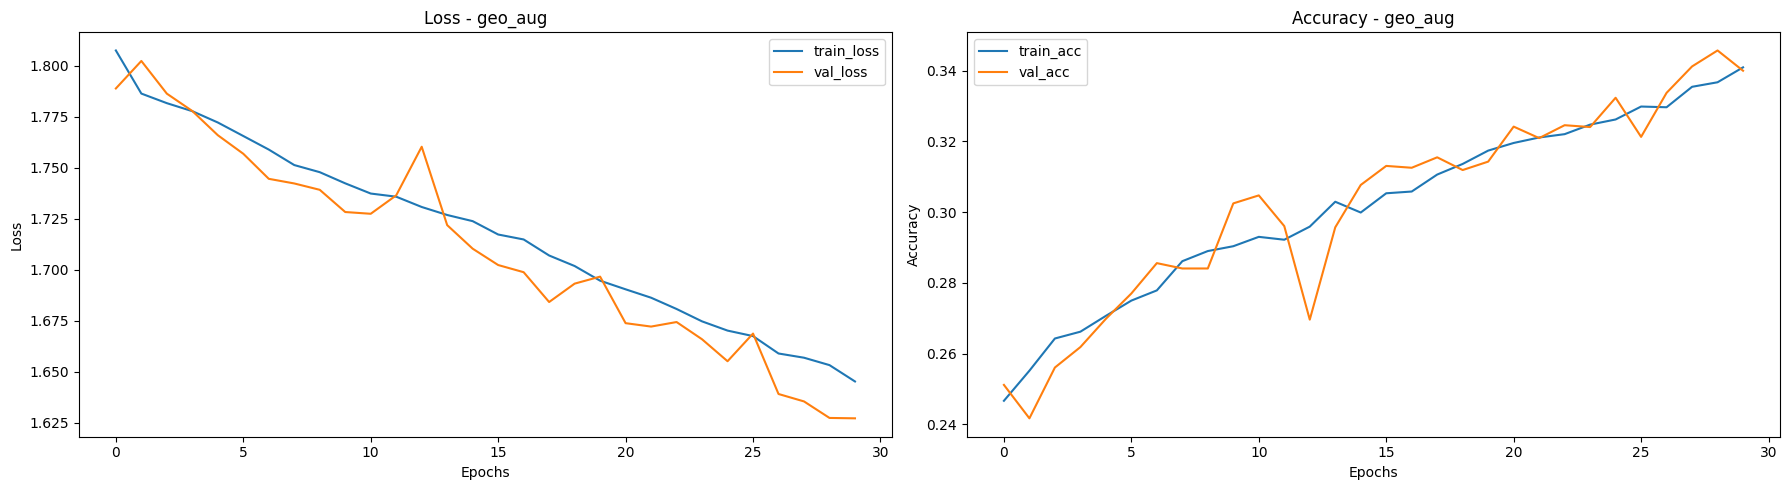



[INFO] Experiment number: 3
[INFO] Transform Approach: non_geo_aug
------------------------------------------------------------
Created SummaryWriter: saving to: runs/2025-09-27/non_geo_aug/baseline_cnn
Epoch 001/030 | Loss: 1.8004 | Acc: 24.86% | Val Loss: 1.7785 | Val Acc: 25.81%
Epoch 002/030 | Loss: 1.7844 | Acc: 25.95% | Val Loss: 1.7784 | Val Acc: 25.85%
Epoch 003/030 | Loss: 1.7773 | Acc: 26.31% | Val Loss: 1.7769 | Val Acc: 25.73%
Epoch 004/030 | Loss: 1.7710 | Acc: 26.98% | Val Loss: 1.7767 | Val Acc: 25.38%
Epoch 005/030 | Loss: 1.7593 | Acc: 27.78% | Val Loss: 1.7417 | Val Acc: 28.44%
Epoch 006/030 | Loss: 1.7503 | Acc: 28.91% | Val Loss: 1.7329 | Val Acc: 29.68%
Epoch 007/030 | Loss: 1.7432 | Acc: 29.04% | Val Loss: 1.7397 | Val Acc: 29.30%
Epoch 008/030 | Loss: 1.7382 | Acc: 29.68% | Val Loss: 1.7485 | Val Acc: 27.99%
Epoch 009/030 | Loss: 1.7331 | Acc: 29.69% | Val Loss: 1.7231 | Val Acc: 30.46%
Epoch 010/030 | Loss: 1.7270 | Acc: 30.13% | Val Loss: 1.7372 | Val Acc: 29

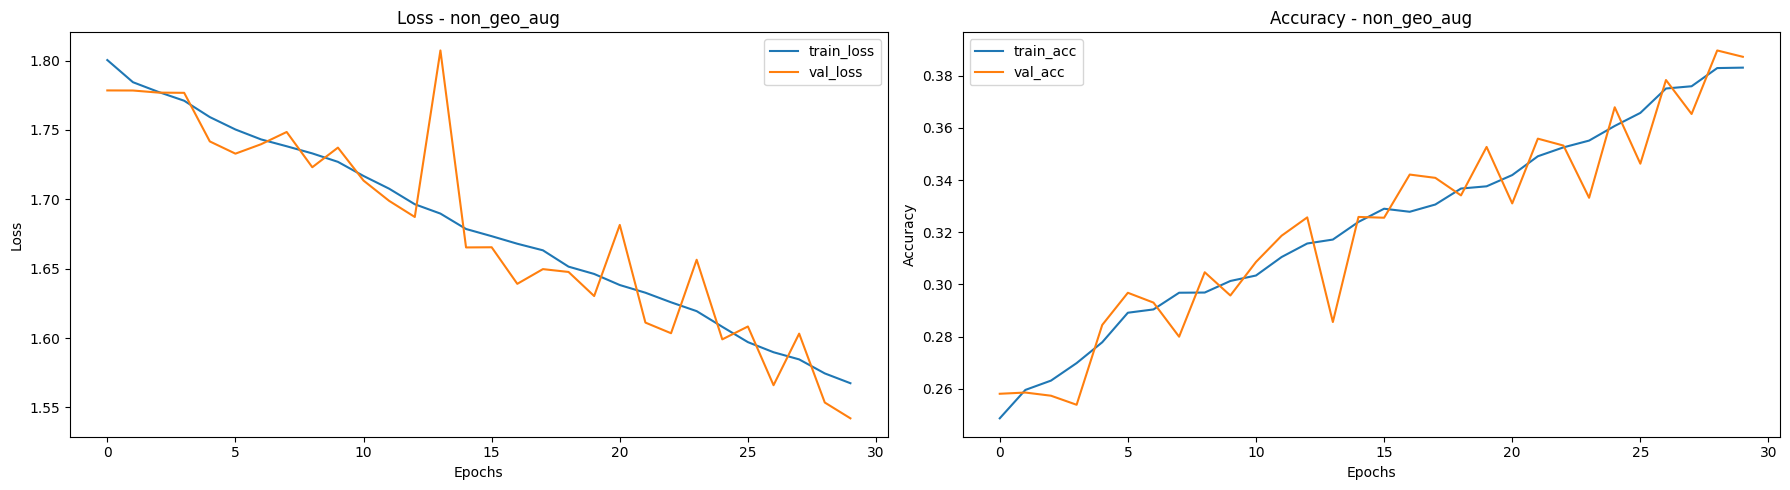

In [9]:
set_seed()
lr = 1e-3
epochs = 30

train_transforms = {'no_aug':base_transforms,
                    'geo_aug':train_transform_geo,
                    'non_geo_aug':train_transform_geo_ngeo}
experiment_number = 0

for t_name, t_transform in train_transforms.items():  # FIXED: .items() not .item()
    # Create new model and optimizer for each experiment
    model = BaseNet(len(class_names)).to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    loss_fn = torch.nn.CrossEntropyLoss()
    
    # Create train dataset with current transform
    train_dataset = TransformDataset(train_subset, t_transform)
    train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                         pin_memory=True, num_workers=NUM_WORKERS)
    
    experiment_number += 1
    print(f"\n[INFO] Experiment number: {experiment_number}")
    print(f"[INFO] Transform Approach: {t_name}")
    print('-' * 60)
    
    # Train model
    results = train(model, train_dl, val_dl, optimizer, loss_fn, epochs, device,
                    writer=create_writer(exp_name=t_name, model_name='baseline_cnn'))
    
    # Plot results for this experiment
    train_loss = results['train_loss']
    train_acc = results['train_acc']
    val_loss = results['val_loss']
    val_acc = results['val_acc']
    
    epochs_ = range(len(train_loss))
    plt.figure(figsize=(18, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_, train_loss, label='train_loss')
    plt.plot(epochs_, val_loss, label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss - {t_name}')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_, train_acc, label='train_acc')
    plt.plot(epochs_, val_acc, label='val_acc')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.title(f'Accuracy - {t_name}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print('=' * 60 + '\n')


In [10]:
# Create timestamped filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
zip_name = f"tensorboard_logs_{timestamp}"

# Compress
shutil.make_archive(zip_name, 'zip', "runs")
print(f"✓ Download {zip_name}.zip from Output tab")

✓ Download tensorboard_logs_20250927_1307.zip from Output tab


In [11]:
# def evaluation_step(model, test_dl, loss_fn, class_names, device):
#     model.eval()
#     test_loss, test_acc = 0, 0
#     y_true, y_pred = [], []

#     with torch.inference_mode():
#         for X, y in test_dl:
#             X, y = X.to(device), y.to(device)
#             outputs = model(X)
#             loss = loss_fn(outputs, y)
#             test_loss += loss.item()

#             preds = outputs.argmax(dim=1)
#             test_acc += (preds == y).sum().item() / len(preds)

#             y_true.extend(y.cpu().numpy())
#             y_pred.extend(preds.cpu().numpy())

#     avg_loss = test_loss / len(test_dl)
#     avg_acc = test_acc / len(test_dl)
#     test_f1 = f1_score(y_true, y_pred, average='macro')
    
#     tqdm.write(f"Test Loss: {avg_loss:.4f} | Test Acc: {avg_acc*100:.2f}% | Test F1: {test_f1:.4f}")

#     cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names_)))
    
#     disp = ConfusionMatrixDisplay(cm, display_labels=class_names_)
    
#     disp.plot(cmap='Blues', xticks_rotation=45)
#     plt.xticks(fontsize=8)
#     plt.yticks(fontsize=8)
#     plt.tight_layout()
#     plt.show()

# evaluation_step(model, test_dl, loss_fn, class_names_, device)